#### Student Name: Ashley Newman
#### Student ID: 806092

# Assignment 4

### Markov Chain, LZify

Instructions: 

* This notebook is an interactive assignment; please read and follow the instructions in each cell. 

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook as a PDF and a WAV file of your Fur Elise variation.

* Make sure to mark the page with your solution for each problem on Gradescope. Any problems without the correct pages marked may receive a score of 0. 

## Markov-Based Chord Prediction

In music, certain chord transitions are more likely than others. This idea can be applied as Markov Models, where the first-order temporal relationships between the various chords are captured by the transition probability matrix $A$. 

If we consider only major and minor chords, there are a total of 24 chords in this model (12 major, from C through B, and 12 minor, from C through B), formalized as:

\begin{equation}
\label{eq:ChordReco:HMM:App:Spec:SetStates}
  \mathcal{A} = \{\mathbf{C},\mathbf{C}^\sharp,\ldots,\mathbf{B},\mathbf{Cm},\mathbf{Cm^\sharp},\ldots,\mathbf{Bm}\} 
\end{equation}

We use the notation $\alpha{i}\rightarrow\alpha{j}$ referring to the transition from state $\alpha{i}$ to state $\alpha{j}$, $i,j\in[1:24]$. For example, the coefficient $a_{1,2}$ expresses the 
probability for the transition $\alpha_{1}\rightarrow\alpha_{2}$ (corresponding to  $\mathbf{C}\rightarrow\mathbf{C}^\sharp$), whereas $a_{1,8}$ expresses the probability for $\alpha_{1}\rightarrow\alpha_{8}$  (corresponding to  $\mathbf{C}\rightarrow\mathbf{G}$). In real music, the change from a tonic to the dominant is much more likely
than transposing by one semitone, so that the probability $a_{1,8}$ should be much larger than $a_{1,2}$. The coefficients $a_{i,i}$ express the probability of staying in state $\alpha_{i}$ (i.e., $\alpha_{i}\rightarrow\alpha_{i}$), $i\in[1:24]$. These coefficients are also referred to as **self-transition** probabilities.

A transition probability matrix can be specified in many ways. For example, the matrix may be defined manually by a music expert based on rules from harmony theory. The most common approach is to generate such a matrix automatically 
by estimating the transition probabilities from labeled data. 

In the following exercise, you will create a Markov model by determining transition probabilities found in the music of the Beatles using bigrams (pairs of adjacent elements) in labeled frame sequences from a subset of the Beatles Corpus.

For this assignment, assume each row in the dataset represents a chord that has followed the chord on the previous row in a Beatles song. When parsing the file for your model, you may discard any chord references beyond key and major/minor quality. For example, if a row reads 'Bbm7', you would parse for the key (B-flat) and quality (minor), but discard the extra information that it is a 7th chord.  

In [11]:
import numpy as np
import pandas as pd
from collections import Counter
from numpy.random import multinomial as randm
from numpy import where
import scipy.signal as si
import IPython.display as ipd
import librosa
import scipy
from matplotlib import patches
import librosa.display as ld
import music21
from music21 import midi as midi21
from music21 import stream
from jchord.progressions import ChordProgression, MidiConversionSettings
import copy
import matplotlib.pyplot as plt


np.random.seed(42)

data = pd.read_csv('Liverpool_band_chord_sequence.csv')

def preprocess(df):
    df[df['chords'] == 'Bb'] = 'A#'  
    chords = ' '.join(map(str, df['chords']))
    return chords

data2 = preprocess(data)



def play(x):
    """Returns nothing. Outputs a midi realization of x, a note or stream.
    Primarily for use in notebooks and web environments.
    """
    prog = ChordProgression.from_string(x)
    prog.to_midi(MidiConversionSettings(filename="example.midi", tempo=100, beats_per_chord=4, instrument=4))
    mf = midi21.MidiFile()
    mf.open("example.midi")
    mf.read()
    mf.close()
    s = midi21.translate.midiFileToStream(mf)
    myStream = stream.Stream()

    myStream.append(s)
    x = myStream
    
    if isinstance(x, stream.Stream):
        x = copy.deepcopy(x)
        for subStream in x.recurse(streamsOnly=True, includeSelf=True):
            mss = subStream.getElementsByClass(stream.Measure)
            for ms in mss:
                ms.offset += 1.0
    if isinstance(x, music21.note.Note):
        s = stream.Stream()
        s.append(music21.note.Rest(1))
        s.append(x)
        x = s
    x.show('midi')


##### Question 1 (20 points)

Using the above data, generate a 24x24 matrix, where each matrix element (i,j) is the transition probability from chord i to chord j. 

In [135]:
import numpy as np
import pandas as pd
from collections import Counter
np.random.seed(42)

# read file
data = pd.read_csv('Liverpool_band_chord_sequence.csv')


In [136]:
# code to make bigrams for trans prob matrix
n = 2
chords = data['chords'].values
ngrams = zip(*[chords[i:] for i in range(n)])
bigrams = [" ".join(ngram) for ngram in ngrams]
bigrams[:5]

['F Em7', 'Em7 A7', 'A7 Dm', 'Dm Dm7', 'Dm7 Bb']

In [137]:
# bigrams = [item.replace('7', '') for item in bigrams]
# bigrams = [item.replace('6', '') for item in bigrams]
# bigrams = [item.replace('4', '') for item in bigrams]
bigrams = [item.replace('Bb', 'A#') for item in bigrams]
# bigrams = [item.replace('sus', '') for item in bigrams] # didn't know how to represent sus in chordprogression.from_string
bigrams[:5]


['F Em7', 'Em7 A7', 'A7 Dm', 'Dm Dm7', 'Dm7 A#']

In [138]:
data = pd.read_csv('Liverpool_band_chord_sequence.csv')


def preprocess(df):
    df[df['chords'] == 'Bb'] = 'A#'  
    df[df['chords'] == 'Em7'] = 'Em'  
    df[df['chords'] == 'A7'] = 'A' 
    df[df['chords'] == 'Dm7'] = 'Dm' 
    df[df['chords'] == 'C7'] = 'C' 
    df[df['chords'] == 'G7'] = 'G' 
    df[df['chords'] == 'A7sus4'] = 'Am' 
    df[df['chords'] == 'Gm6'] = 'Gm' 
    df[df['chords'] == 'Fsus4'] = 'Fm' 
    chords = ' '.join(map(str, df['chords']))
    return chords



data = preprocess(data)
data

'F Em A Dm Dm A# C F C Dm G A# F F Em A Dm Dm A# C F C Dm G A# F Am A Dm C A# Dm Gm C F Am A Dm C A# Dm Gm C F Fm F F Em A Dm Dm A# C F C Dm G A# F Am A Dm C A# Dm Gm C F Am A Dm C A# Dm Gm C F Fm F F Em A Dm Dm A# C F C Dm G A# F G A# F'

In [139]:
data2 = data.split(' ')

trans_matrix = pd.crosstab(pd.Series(data2[1:],name='State J'),
            pd.Series(data2[:-1],name='State I'),normalize=1)


# major = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
# minor = ['Cm', 'C#m', 'Dm', 'D#m', 'Em', 'Fm', 'F#m', 'Gm', 'G#m', 'Am', 'A#m', 'Bm']
trans_matrix


State I,A,A#,Am,C,Dm,Em,F,Fm,G,Gm
State J,,,,,,,,,,
A,0.0,0.000000,1.0,0.00,0.0,1.0,0.000000,0.0,0.0,0.0
A#,0.0,0.000000,0.0,0.25,0.2,0.0,0.000000,0.0,1.0,0.0
Am,0.0,0.000000,0.0,0.00,0.0,0.0,0.222222,0.0,0.0,0.0
C,0.0,0.307692,0.0,0.00,0.2,0.0,0.222222,0.0,0.0,1.0
Dm,1.0,0.307692,0.0,0.25,0.2,0.0,0.000000,0.0,0.0,0.0
Em,0.0,0.000000,0.0,0.00,0.0,0.0,0.222222,0.0,0.0,0.0
F,0.0,0.384615,0.0,0.50,0.0,0.0,0.166667,1.0,0.0,0.0
Fm,0.0,0.000000,0.0,0.00,0.0,0.0,0.111111,0.0,0.0,0.0
G,0.0,0.000000,0.0,0.00,0.2,0.0,0.055556,0.0,0.0,0.0


In [140]:
values = np.zeros((10,13))
col = ['C#', 'D', 'D#', 'E', 'F#', 'G#', 'B'
      'Cm', 'C#m', 'D#m', 'F#m', 'G#m', 'A#m', 'Bm']
df_add = pd.DataFrame(data=values, columns=col)
mod = pd.concat([trans_matrix, df_add], axis=1)
mod = mod.reindex(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B',
                  'Cm', 'C#m', 'Dm', 'D#m', 'Em', 'Fm', 'F#m', 'Gm', 'G#m', 'Am', 'A#m', 'Bm'],
                 axis='columns').reindex(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B',
                  'Cm', 'C#m', 'Dm', 'D#m', 'Em', 'Fm', 'F#m', 'Gm', 'G#m', 'Am', 'A#m', 'Bm'])
mod = mod.fillna(0.0)
mod = mod.T
mod = mod.to_numpy()
MM = mod
MM

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5       , 0.        , 0.        , 0.        , 0.        ,
        0.25      , 0.        , 0.        , 0.        , 0.25      ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.   

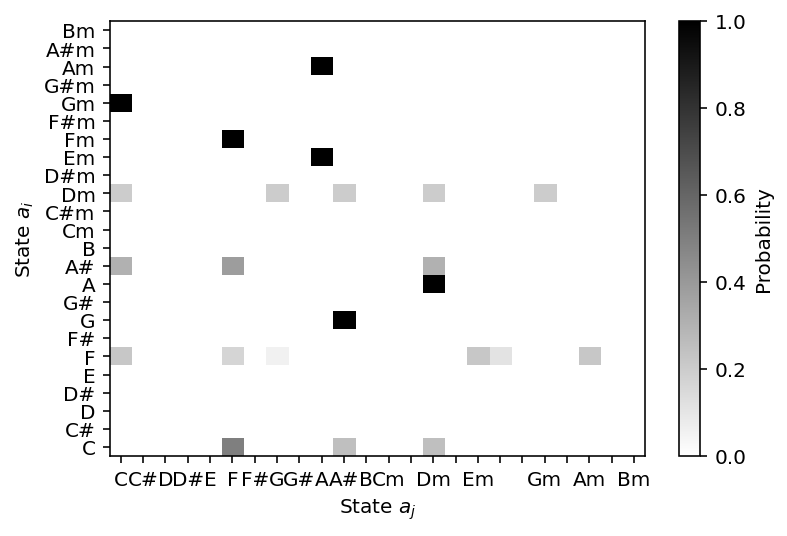

In [141]:
def plot_transition_matrix(A, ax=None, xlabel='State $a_j$', ylabel='State $a_i$', title='', clim=[-6, 0], cmap='gray_r'):
    
    im = plt.imshow(A, origin='lower', aspect='auto', cmap=cmap)
    im.set_clim([0, 1])
    cbar = plt.colorbar(im)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    cbar.ax.set_ylabel('Probability')
    
    chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_label_maj = chroma_label
    chord_label_min = [s + 'm' for s in chroma_label]
    chord_labels = chord_label_maj + chord_label_min
    chord_labels_squeezed = chord_labels.copy()
    for k in [13, 15, 17, 18, 20, 22]:
        chord_labels_squeezed[k] = ''
        
    plt.xticks(np.arange(24), labels=chord_labels_squeezed )
    plt.yticks(np.arange(24), labels=chord_labels)
    
    return im

plot_transition_matrix(MM);

##### Question 2 (10 points)

Using your MM, you will create your own 16-measure Beatles hits!
For your first song, beginning on C major, select each next chord by choosing the chord with the largest transition probability from the current chord.

Make sure your chord progression string is formatted like this: 'C Dm G C'

Otherwise, it may not play in the in-browser MIDI player. 

In [142]:
my_first_beatles_hit = 'C'


def predict_next_state(chord:str, data:list=bigrams):
    bigrams_with_current_chord = [bigram for bigram in bigrams if bigram.split(' ')[0]==chord]
    count_appearance = dict(Counter(bigrams_with_current_chord))
    for ngram in count_appearance.keys():
        count_appearance[ngram] = count_appearance[ngram]/len(bigrams_with_current_chord)
    options = [key.split(' ')[1] for key in count_appearance.keys()]
    probabilities = list(count_appearance.values())
    max_value = max(probabilities)
    max_index = probabilities.index(max_value)
    result = options[max_index]
    return result

    

def generate_sequence(chord:str=None, data:list=bigrams, length:int=16):
    """Generate sequence of defined length."""
    # create list to store future chords
    chords = []
    for n in range(length):
        # append next chord for the list
        chords.append(predict_next_state(chord, bigrams))
        # use last chord in sequence to predict next chord
        chord = chords[-1]
    return chords

beatles = generate_sequence(my_first_beatles_hit)
beatles = ' '.join(beatles)
beatles = my_first_beatles_hit + " " + beatles
print(beatles)




C Dm7 A# F Em7 A7 Dm Dm7 A# F Em7 A7 Dm Dm7 A# F Em7


In [143]:
play(beatles)

##### Question 3 (10 points)

For your second song, beginning on C major, select each next chord at random according to the probabilities of your MM.
For example, if C major transitions to G major with probability .5, F major with probability .25, and D minor with probability .25, then your next chord should be selected randomly from (G, F, Dm) with probability of selection (.5, .25, .25) respectively. 

In [144]:
my_second_beatles_hit = 'C'

### Your code here:

def predict_next_state(chord:str, data:list=bigrams):
    """Predict next chord based on current state."""
    # create list of bigrams which stats with current chord
    bigrams_with_current_chord = [bigram for bigram in bigrams if bigram.split(' ')[0]==chord]
    # count appearance of each bigram
    count_appearance = dict(Counter(bigrams_with_current_chord))
    # convert appearance into probabilities
    for ngram in count_appearance.keys():
        count_appearance[ngram] = count_appearance[ngram]/len(bigrams_with_current_chord)
    # create list of possible options for the next chord
    options = [key.split(' ')[1] for key in count_appearance.keys()]
    # create  list of probability distribution
    probabilities = list(count_appearance.values())
    # return random prediction
    return np.random.choice(options, p=None)

def generate_sequence(chord:str=None, data:list=bigrams, length:int=16):
    """Generate sequence of defined length."""
    # create list to store future chords
    chords = []
    for n in range(length):
        # append next chord for the list
        chords.append(predict_next_state(chord, bigrams))
        # use last chord in sequence to predict next chord
        chord = chords[-1]
    return chords


beatles2 = generate_sequence(my_second_beatles_hit)
beatles2 = ' '.join(beatles2)
beatles2 = my_second_beatles_hit + " " + beatles2
print(beatles2)


C Dm7 G7 A# C7 F F Fsus4 F Fsus4 F C Dm7 A# Dm Gm6 C7


In [145]:
play(beatles2)

## LZify: Applying Universal Prediction to Musical Style

LZify was the first algorithmic learning method to create a style immitation from a dictionary of motifs of variable size. It is based on the Lempel-Ziv compression method. Because the viriable context (motif) size that is used for perdiction of the next note, the method became also know as Variable Memory Markov model. Strictly speaking, is not a correct term, but LZ prediciton is known to perform asymptotically as good as any finite Markov model, so the terminology is partially justified. 

In this section, you will implement the Incremental Parsing (IP) from the Lempel Ziv LZ78 method for creating a dictionary of motifs. These motifs are later used to generate new sequences resembling the input sequence.

Please read the algorithm in Assayag, Dubnov, and Delerue's "Guessing the Composer’s Mind" (available at https://pdfs.semanticscholar.org/0181/236e1b417c8dd5dddd1f919583893f7a9026.pdf). 

The IPMotif function should compute the motif dictionary discovered in the text. It uses Incremental Parsing method to parse the text into unseen motifs.

##### Question 4 (20 points)

The text below contains an excerpt of Beethoven's Fur Elise, written as MML (Music Macro Language). MML is used to represent musical melodies as text. 

You can read more about MML syntax here: https://en.wikipedia.org/wiki/Music_Macro_Language

You can play with MML in this webapp: https://firecomb.github.io/final%20project.html

Try playing the text below in the webapp to hear sample output. 

In [83]:
def IPMotif(text):
    """Compute an associative dictionary (the motif dictionary)."""
    
    dictionary = {}
    motif = ""
    
    for ele in text:
        motif += ele
        if motif in dictionary:
            dictionary[motif]+= 1
        else:
            dictionary[motif] = 1
            motif = ""
    
    ### Your Code Here:
    return dictionary

In [84]:
test = 'o6ed+ed+ec-dc>aceabeg+bb+e<ed+ed+ec-dc>aceabe<c>bab<cde>g<fed>f<edc>e<dc>be<eeed+ed+ec-dc>aceabeg+bb+e<ed+ed+ec-dc>aceabe<c>ba'
dict1 = IPMotif(test)
print(dict1)

{'o': 1, '6': 1, 'e': 13, 'd': 5, '+': 7, 'ed': 6, '+e': 4, 'c': 9, '-': 3, 'dc': 3, '>': 3, 'a': 4, 'ce': 3, 'ab': 1, 'eg': 1, '+b': 2, 'b': 5, '+e<': 2, 'ed+': 4, 'ed+e': 3, 'c-': 1, 'dc>': 2, 'ac': 1, 'ea': 1, 'be': 2, '<': 4, 'c>': 3, 'ba': 1, 'b<': 1, 'cd': 1, 'e>': 1, 'g': 1, '<f': 1, 'ed>': 1, 'f': 1, '<e': 1, 'dc>e': 1, '<d': 1, 'c>b': 1, 'e<': 2, 'ee': 1, 'ed+ed': 1, '+ec': 1, '-d': 2, 'c>a': 1, 'cea': 2, 'beg': 1, '+bb': 1, '+e<e': 1, 'd+': 1, 'ed+ec': 1, '-dc': 1, '>a': 1, 'ceab': 1, 'e<c': 1, '>b': 1}


Next, implement the IPContinuation and Normalize functions. 
The IPContinuation function transforms the IPMotif dictionary into a tree-like representation to allow finding continuations for new  motifs. The Normalize function turns the counters in every element of the IPContinuation dictionary into probabilities. 

##### Question 5 (20 points)

In [85]:
def IPContinuation(dict1):
    """Compute continuation dictionary from a motif dictionary"""

    dict2 = {}
    for ele in dict1:
        counter = dict1[ele]
        i = ele[:-1] ; j = ele[-1]
        if i in dict2:
            dict2[i].append((j,counter))
        else:
            dict2[i] = [(j,counter)]
    dict2 = Normalize(dict2)
    return dict2
        

        
# dict1 = IPMotif('abababcabdabcdabce')  #dict1 from paper ----testing
# dict2 = IPContinuation(dict1)
# dict2

##### Question 6 (10 points)

In [86]:
def Normalize(dict2):
    """Turns the counters in every element of dict2 to probabilities"""

    ### Your Code Here:
    for i in dict2:
        num = [n[1] for n in dict2[i]]
        sm = sum(num)
        for j, n in enumerate(dict2[i]):
            dict2[i][j] = (n[0] , float(n[1])/sm)
    return dict2



Generting a new sequence is done by traversing the IPContinuation tree and selecting possible branches according to their weights. If motif is not found, its last symbol is removed and the process is repeated for a shorter motif.

In [87]:
dict2 = IPContinuation(dict1)
print(dict2)

{'': [('o', 0.017543859649122806), ('6', 0.017543859649122806), ('e', 0.22807017543859648), ('d', 0.08771929824561403), ('+', 0.12280701754385964), ('c', 0.15789473684210525), ('-', 0.05263157894736842), ('>', 0.05263157894736842), ('a', 0.07017543859649122), ('b', 0.08771929824561403), ('<', 0.07017543859649122), ('g', 0.017543859649122806), ('f', 0.017543859649122806)], 'e': [('d', 0.5), ('g', 0.08333333333333333), ('a', 0.08333333333333333), ('>', 0.08333333333333333), ('<', 0.16666666666666666), ('e', 0.08333333333333333)], '+': [('e', 0.6666666666666666), ('b', 0.3333333333333333)], 'd': [('c', 0.75), ('+', 0.25)], 'c': [('e', 0.375), ('-', 0.125), ('>', 0.375), ('d', 0.125)], 'a': [('b', 0.5), ('c', 0.5)], '+e': [('<', 0.6666666666666666), ('c', 0.3333333333333333)], 'ed': [('+', 0.8), ('>', 0.2)], 'ed+': [('e', 1.0)], 'dc': [('>', 1.0)], 'b': [('e', 0.5), ('a', 0.25), ('<', 0.25)], '<': [('f', 0.3333333333333333), ('e', 0.3333333333333333), ('d', 0.3333333333333333)], 'dc>': [('

In [88]:
def IPGenerate(n,dict2):
    p = 0
    out = ""
    for k in range(n):
        while True:
            context = out[-p:]
            if context in dict2:
                prob = [tup[1] for tup in dict2[context]]
                conti = where(randm(1,prob))[0][0]
                cont = dict2[context][conti][0]
                out = out + cont
                break
            else:
                p = p-1
    return out
out = IPGenerate(92,dict2)
print(out)

+e<ed+ec>begb<dc>eac>bege>bac>aceab<f<dc>ed+ed+eceabeged+ec>aceab<f<dc>ed+ed+ec>b<dc>ed+ed+e


##### Question 7 (10 points)

Paste your output in the online MML player, and listen to your piece. Do you hear elements of Fur Elise in your composition? What are some of the differences in the output from the original? 

Please export the WAV file of your output from the webapp, and submit the WAV file with your assignment. 

I heard a lot of similar elements in the song to the Flur Elise, but the pitch was very different (starting like a high squeek). It can still be recognized as related to Flur Elise but it has a unique sound and is less auditorily pleasing. It sounded like an out of tune version of Flur Elise.

I had some bugs to fix with implementation, but I expected to not hear the exact same output after my functions parsed the MML. I suspect there will be a similar melody, but a different tempo after the manipulation.

A few important points:
1. The method captures the "texture" of the language but not it's meaning.
2. We could parse a new text using IPMotifs from two languages, then count the length and number of motifs in order to decide what was the language of the new text.
3. In order to use this method with musical information, we need first to translate audio to features, or in case of polyphonic midi change this into some proper representation. One possibility is using virtual fundamental or chroma for harmony, or some other specialized representation to capture repetition in terms of other specific musical properties.